Three images of the same scene are analyzed from June 20, 1994 (19940620):
- LT5_L1: Landsat 5 Level 1 – Raw image without atmospheric correction accessed from USGS.
- LT5_L2: Landsat 5 Level 2 – USGS image pre-processed through an atmospheric correction algorithm.
- LT5_L1_acolite: Landsat 5 Level 1 – The raw image processed for atmospheric correction using Acolite.

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import ee
import geemap
Map= geemap.Map()

In [105]:
import geemap
import ee
import geopandas as gpd
import json

# Initialize Earth Engine
ee.Initialize()

# Define the path to the shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Ensure the geometry is valid
gdf = gdf[gdf.is_valid]

# Compute the centroid of the shapefile
centroid = gdf.geometry.centroid.iloc[0]
center = [centroid.y, centroid.x]

# Convert the shapefile to GeoJSON format
geojson = json.loads(gdf.to_json())

# # Define the coordinates (Big Moose Lake)
# latitude = 43.82569819
# longitude = -74.8592526

# # Initialize the map centered around the lake point
# center = [latitude, longitude]
# m = geemap.Map(center=center, zoom=14)

# Initialize the map centered around the centroid of the shapefile
m = geemap.Map(center=center, zoom=14)

# Add the GeoJSON layer to the map
m.add_geojson(geojson, layer_name='Big Moose Lake', style={'color': 'black', 'fillOpacity': 0.1})

# Display the map
m


Map(center=[43.83093011202657, -74.84825860013233], controls=(WidgetControl(options=['position', 'transparent_…

## Initial Image Processing (L1, L2, Acolite, FLAASH)

In [106]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import pandas as pd

# Define file paths for the shapefile and all bands
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"
b1_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B1.TIF"
b2_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B2.TIF"
b3_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B3.TIF"
b4_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B4.TIF"
b5_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B5.TIF"
b6_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B6.TIF"
b7_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_B7.TIF"
qa_pixel_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_QA_PIXEL.TIF"
qa_radsat_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_QA_RADSAT.TIF"
saa_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_SAA.TIF"
sza_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_SZA.TIF"
vaa_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_VAA.TIF"
vza_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_usgs\LT05_L1TP_015030_19940620_20200913_02_T1_VZA.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff, qa_pixel_tiff, qa_radsat_tiff, saa_tiff, sza_tiff, vaa_tiff, vza_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7',
    qa_pixel_tiff: 'QA_PIXEL',
    qa_radsat_tiff: 'QA_RADSAT',
    saa_tiff: 'SAA',
    sza_tiff: 'SZA',
    vaa_tiff: 'VAA',
    vza_tiff: 'VZA'
}

# Radiance and Reflectance scaling factors (from the MTL file)
radiance_mult = {
    'B1': 7.6583E-01, 'B2': 1.4482E+00, 'B3': 1.0440E+00,
    'B4': 8.7602E-01, 'B5': 1.2035E-01, 'B6': 5.5375E-02, 'B7': 6.5551E-02
}

radiance_add = {
    'B1': -2.28583, 'B2': -4.28819, 'B3': -2.21398,
    'B4': -2.38602, 'B5': -0.49035, 'B6': 1.18243, 'B7': -0.21555
}

reflectance_mult = {
    'B1': 0.0001810338, 'B2': 0.0001840138, 'B3': 0.0002071548,
    'B4': 0.0002290102, 'B5': 0.0002301660, 'B6': None, 'B7': 0.0002383882
}

reflectance_add = {
    'B1': -0.02982, 'B2': -0.01518, 'B3': -0.00525,
    'B4': 0.00399, 'B5': -0.00212, 'B6': None, 'B7': -0.00072
}

# Load the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Initialize empty DataFrame
LT5_L1 = pd.DataFrame()

# Open the first TIFF file to get the spatial information and create the mask
with rasterio.open(tiff_files[0]) as src:
    # Transform the shapefile geometry to the coordinate reference system of the image
    gdf = gdf.to_crs(src.crs)
    
    # Create a mask for the shapefile geometry
    mask = geometry_mask([feature['geometry'] for feature in gdf.iterfeatures()], transform=src.transform, invert=True, out_shape=(src.height, src.width))
    
    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_mask = band_data[mask]
    
    # Get the pixel coordinates within the mask
    rows, cols = np.where(mask)
    
    # Add the values as a new column in the DataFrame
    LT5_L1[column_names[tiff_files[0]]] = values_within_mask
    
    # Add 'row' and 'col' columns to DataFrame before 'B1'
    LT5_L1.insert(0, 'row', rows)
    LT5_L1.insert(1, 'col', cols)

# Loop through the rest of the TIFF files and add the data to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask
        band_data = src.read(1)
        values_within_mask = band_data[mask]
        
        # Add the values as a new column in the DataFrame
        LT5_L1[column_names[tiff_file]] = values_within_mask

# Apply radiance and reflectance conversion
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']:
    # Convert DN to radiance
    LT5_L1[band] = LT5_L1[band] * radiance_mult[band] + radiance_add[band]
    
    # Convert radiance to reflectance
    if reflectance_mult[band] is not None:
        LT5_L1[band] = LT5_L1[band] * reflectance_mult[band] + reflectance_add[band]

# Calculate and print mean values within the mask for each band
for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']:
    mean_value = np.mean(LT5_L1[band])
    print(f"Mean value for {band} within mask: {mean_value}")

# Print the DataFrame
LT5_L1


Mean value for B1 within mask: -0.022557876997632186
Mean value for B2 within mask: -0.010672435235008226
Mean value for B3 within mask: -0.002359481405356607
Mean value for B4 within mask: 0.007109995185691076
Mean value for B5 within mask: -0.0018613716508476636
Mean value for B6 within mask: 125.61230380660292
Mean value for B7 within mask: -0.0006620858760764417


,row,col,B1,B2,B3,B4,B5,B6,B7,QA_PIXEL,QA_RADSAT,SAA,SZA,VAA,VZA
0,1208,6077,-0.022193,-0.009573,-0.001383,0.013876,-0.000903,129,-0.000506,7440,0,12088,3146,-8072,383
1,1208,6078,-0.022886,-0.010373,-0.002032,0.010465,-0.001485,129,-0.000631,7440,0,12088,3146,-8072,384
2,1208,6079,-0.022747,-0.010373,-0.001816,0.009863,-0.001540,130,-0.000615,7440,0,12088,3146,-8072,384
3,1208,6080,-0.022747,-0.010373,-0.001816,0.011067,-0.001346,131,-0.000553,7440,0,12088,3146,-8072,384
4,1209,6075,-0.022193,-0.009573,-0.001167,0.017086,-0.000820,128,-0.000474,7440,0,12088,3146,-8073,383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5538,1327,5903,-0.022747,-0.010639,-0.002248,0.008860,-0.001651,127,-0.000599,5440,0,12076,3149,-8102,346
5539,1327,5904,-0.022747,-0.010639,-0.002032,0.010866,-0.001623,127,-0.000599,5440,0,12076,3149,-8102,346
5540,1327,5905,-0.022193,-0.010106,-0.001600,0.012070,-0.001263,128,-0.000553,5440,0,12076,3149,-8101,346
5541,1327,5906,-0.022054,-0.009307,-0.000951,0.014076,-0.001014,129,-0.000506,5440,0,12076,3149,-8101,347


In [107]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import pandas as pd

# Define file paths for the shapefile and all bands
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"
b1_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_486_SRB1.tif"
b2_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2.tif"
b3_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3.tif"
b4_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_839_SRB4.tif"
b5_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_1678_SRB5.tif"
b6_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L1R_bt6.tif"
b7_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_2217_SRB7.tif"
sza_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_sza.tif"
vza_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L1TP_015030_19940620_20200913_02_T1_acolite\L5_TM_1994_06_20_15_04_03_015030_L2R_vza.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff, sza_tiff, vza_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7',
    sza_tiff: 'SZA',
    vza_tiff: 'VZA'
}

# Initialize empty DataFrame
LT5_L1_acolite = pd.DataFrame()

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Transform the shapefile geometry to the coordinate reference system of the image
    lake_shape = gdf.to_crs(src.crs)

    # Create a mask for the lake shape
    mask = geometry_mask([lake_shape.geometry[0]], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_mask = band_data[mask]

    # Get the pixel coordinates within the mask
    rows, cols = np.where(mask)

    # Add the values as a new column in the DataFrame
    LT5_L1_acolite[column_names[tiff_files[0]]] = values_within_mask

    # Add 'row' and 'col' columns to DataFrame before 'B1'
    LT5_L1_acolite.insert(0, 'col', cols)
    LT5_L1_acolite.insert(0, 'row', rows)

    # Calculate the mean value within the mask for the first band
    mean_value = np.mean(values_within_mask)
    print(f"Mean value for {column_names[tiff_files[0]]} within lake shape: {mean_value}")

# Now iterate over the remaining TIFF files to add additional bands to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask for the current band
        band_data = src.read(1)
        values_within_mask = band_data[mask]

        # Extract band name from file path
        band_name = column_names[tiff_file]

        # Add the values as a new column in the existing DataFrame
        LT5_L1_acolite[band_name] = values_within_mask

        # Calculate the mean value within the mask for the current band
        mean_value = np.mean(values_within_mask)
        print(f"Mean value for {band_name} within lake shape: {mean_value}")

# Print the DataFrame (for verification)
LT5_L1_acolite

Mean value for B1 within lake shape: 0.008085757493972778
Mean value for B2 within lake shape: 0.015263913199305534
Mean value for B3 within lake shape: 0.008854066021740437
Mean value for B4 within lake shape: 0.03787775710225105
Mean value for B5 within lake shape: 0.012550920248031616
Mean value for B6 within lake shape: 291.3264465332031
Mean value for B7 within lake shape: 0.004292987287044525
Mean value for SZA within lake shape: 31.47500991821289
Mean value for VZA within lake shape: 3.6385393142700195


,row,col,B1,B2,B3,B4,B5,B6,B7,SZA,VZA
0,1208,6078,0.009934,0.026522,0.020979,0.103801,0.053471,292.879242,0.018085,31.459999,3.84
1,1208,6079,-0.005721,0.005922,0.001752,0.069559,0.024717,293.324921,0.000000,31.459999,3.84
2,1208,6080,0.011782,0.026531,0.024014,0.114475,0.065870,293.768921,0.035521,31.459999,3.84
3,1209,6076,0.015429,0.030280,0.020971,0.125125,0.065864,292.431946,0.028545,31.459999,3.83
4,1209,6077,0.002756,0.008367,0.003456,0.045331,0.018890,292.431946,0.000000,31.459999,3.83
...,...,...,...,...,...,...,...,...,...,...,...
5546,1327,5906,0.019864,0.040754,0.035373,0.167324,0.095353,292.879242,0.045877,31.490000,3.47
5547,1327,5907,0.027207,0.052050,0.047485,0.220400,0.112708,293.324921,0.063342,31.490000,3.47
5548,1327,5908,0.032706,0.059568,0.053536,0.223932,0.162226,293.324921,0.087779,31.490000,3.47
5549,1328,5902,0.014327,0.033197,0.020195,0.248604,0.110225,292.879242,0.049368,31.490000,3.46


In [108]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import pandas as pd

# Define file paths for the shapefile and all bands
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"
b1_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_SR_B1.TIF"
b2_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2.TIF"
b3_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3.TIF"
b4_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_SR_B4.TIF"
b5_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_SR_B5.TIF"
b6_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_ST_B6.TIF"
b7_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_SR_B7.TIF"
qa_pixel_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_QA_PIXEL.TIF"
qa_radsat_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\LT05_L2SP_015030_19940620_20200913_02_T1_usgs\LT05_L2SP_015030_19940620_20200913_02_T1_QA_RADSAT.TIF"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b6_tiff, b7_tiff, qa_pixel_tiff, qa_radsat_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b6_tiff: 'B6',
    b7_tiff: 'B7',
    qa_pixel_tiff: 'QA_PIXEL',
    qa_radsat_tiff: 'QA_RADSAT'
}

# Define the scale factor and offset for surface reflectance and surface temperature bands
scale_factor_reflectance = 0.0000275
offset_reflectance = -0.2
scale_factor_temperature = 0.00341802
offset_temperature = 149.0

# Initialize empty DataFrame
LT5_L2 = pd.DataFrame()

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Transform the shapefile geometry to the coordinate reference system of the image
    lake_shape = gdf.to_crs(src.crs)

    # Create a mask for the lake shape
    mask = geometry_mask([lake_shape.geometry[0]], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_mask = band_data[mask] * scale_factor_reflectance + offset_reflectance  # Rescale the values

    # Get the pixel coordinates within the mask
    rows, cols = np.where(mask)

    # Add the values as a new column in the DataFrame
    LT5_L2[column_names[tiff_files[0]]] = values_within_mask

    # Add 'row' and 'col' columns to DataFrame before 'B1'
    LT5_L2.insert(0, 'col', cols)
    LT5_L2.insert(0, 'row', rows)

    # Calculate the mean value within the mask for the first band
    mean_value = np.mean(values_within_mask)
    print(f"Mean value for {column_names[tiff_files[0]]} within lake shape: {mean_value}")

# Now iterate over the remaining TIFF files to add additional bands to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask for the current band
        band_data = src.read(1)
        if tiff_file == b6_tiff:
            # Apply scale factor and offset for surface temperature
            values_within_mask = band_data[mask] * scale_factor_temperature + offset_temperature
        else:
            # Apply scale factor and offset for reflectance
            values_within_mask = band_data[mask] * scale_factor_reflectance + offset_reflectance

        # Extract band name from file path
        band_name = column_names[tiff_file]

        # Add the values as a new column in the existing DataFrame
        LT5_L2[band_name] = values_within_mask

        # Calculate the mean value within the mask for the current band
        mean_value = np.mean(values_within_mask)
        print(f"Mean value for {band_name} within lake shape: {mean_value}")

# Print the DataFrame (for verification)
LT5_L2

Mean value for B1 within lake shape: 0.018942294335197542
Mean value for B2 within lake shape: 0.024683885531300735
Mean value for B3 within lake shape: 0.01903466714775392
Mean value for B4 within lake shape: 0.04670615641349449
Mean value for B5 within lake shape: 0.021663836821215945
Mean value for B6 within lake shape: 295.1380617372001
Mean value for B7 within lake shape: 0.012414658578387153
Mean value for QA_PIXEL within lake shape: -0.042116095074869214
Mean value for QA_RADSAT within lake shape: -0.19999999999999998


,row,col,B1,B2,B3,B4,B5,B6,B7,QA_PIXEL,QA_RADSAT
0,1208,6077,0.024647,0.040790,0.033227,0.169023,0.107010,297.393338,0.047445,0.0046,-0.2
1,1208,6078,0.015517,0.029542,0.024125,0.107615,0.055255,297.492461,0.019450,0.0046,-0.2
2,1208,6079,0.017333,0.029542,0.027122,0.096753,0.050333,298.162393,0.022970,0.0046,-0.2
3,1208,6080,0.017333,0.029542,0.027122,0.118478,0.067575,298.678514,0.036967,0.0046,-0.2
4,1209,6075,0.024647,0.040790,0.036252,0.226662,0.114380,296.709734,0.054457,0.0046,-0.2
...,...,...,...,...,...,...,...,...,...,...,...
5538,1327,5903,0.016315,0.025087,0.020577,0.078493,0.040405,296.330334,0.026462,-0.0504,-0.2
5539,1327,5904,0.016288,0.025087,0.023630,0.114820,0.042880,296.344006,0.026462,-0.0504,-0.2
5540,1327,5905,0.023657,0.032650,0.029735,0.136600,0.074972,296.931906,0.036967,-0.0504,-0.2
5541,1327,5906,0.025500,0.043980,0.038892,0.172790,0.097193,297.506133,0.047473,-0.0504,-0.2


### ENVI FLAASH

#### Paramters:
##### Radiometric Calibration: Scale = 1; FLAASH: Input Scale = 1, Sensor = Multispectral, Output Reflectance Scale = 10000

Number of bands: 6
Dimensions: 7971 x 7281


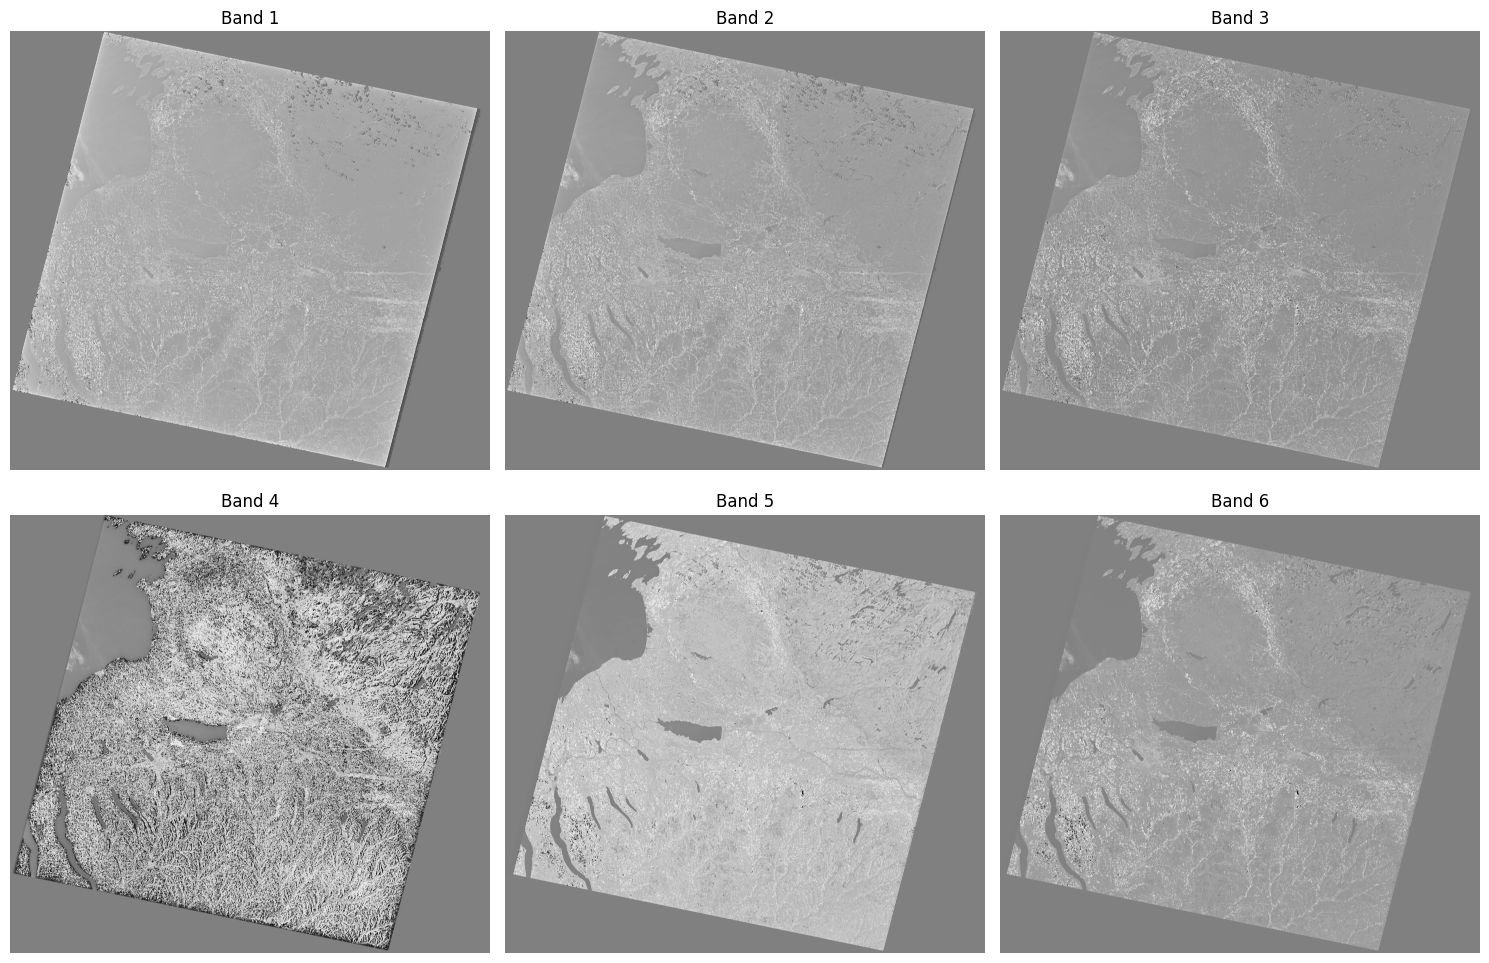

In [169]:
import rasterio
import matplotlib.pyplot as plt
import os

# Path to the GeoTIFF file
file_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\FLAASH_result.tif"
# output_dir = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands"

# # Create the output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the number of bands and the dimensions
    num_bands = src.count
    height = src.height
    width = src.width
    
    print(f"Number of bands: {num_bands}")
    print(f"Dimensions: {width} x {height}")
    
    # Read the entire image into a numpy array (bands, height, width)
    img = src.read()
    
    # Display and save each band separately
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    
    for i, ax in enumerate(axes.flatten()):
        if i < num_bands:
            band_img = img[i, :, :]
            
            # Display each band separately
            ax.imshow(band_img, cmap='gray')
            ax.set_title(f"Band {i+1}")
            ax.axis('off')
            
            # # Save each band as a separate TIFF file
            # output_path = os.path.join(output_dir, f"Band_{i+1}.tif")
            # with rasterio.open(
            #     output_path,
            #     'w',
            #     driver='GTiff',
            #     height=height,
            #     width=width,
            #     count=1,
            #     dtype=band_img.dtype,
            #     crs=src.crs,
            #     transform=src.transform
            # ) as dst:
            #     dst.write(band_img, 1)
    
    plt.tight_layout()
    plt.show()

# print("Band images have been saved successfully.")


In [249]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import pandas as pd

# Define file paths for the shapefile and all bands
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"
b1_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_1.tif"
b2_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_2.tif"
b3_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_3.tif"
b4_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_4.tif"
b5_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_5.tif"
b7_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_6.tif"

# List of TIFF files
tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# Define custom column names for each band
column_names = {
    b1_tiff: 'B1',
    b2_tiff: 'B2',
    b3_tiff: 'B3',
    b4_tiff: 'B4',
    b5_tiff: 'B5',
    b7_tiff: 'B7'
}

# Initialize empty DataFrame
LT5_L1_FLAASH = pd.DataFrame()

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Open the first TIFF file to get the spatial information
with rasterio.open(tiff_files[0]) as src:
    # Transform the shapefile geometry to the coordinate reference system of the image
    lake_shape = gdf.to_crs(src.crs)

    # Create a mask for the lake shape
    mask = geometry_mask([lake_shape.geometry[0]], transform=src.transform, invert=True, out_shape=(src.height, src.width))

    # Read the data within the mask for the first band
    band_data = src.read(1)
    values_within_mask = band_data[mask] / 32768.0  # Divide by 10,000

    # Get the pixel coordinates within the mask
    rows, cols = np.where(mask)

    # Add the values as a new column in the DataFrame
    LT5_L1_FLAASH[column_names[tiff_files[0]]] = values_within_mask

    # Add 'row' and 'col' columns to DataFrame before 'B1'
    LT5_L1_FLAASH.insert(0, 'col', cols)
    LT5_L1_FLAASH.insert(0, 'row', rows)

    # Calculate the mean value within the mask for the first band
    mean_value = np.mean(values_within_mask)
    print(f"Mean value for {column_names[tiff_files[0]]} within lake shape: {mean_value}")

# Now iterate over the remaining TIFF files to add additional bands to the DataFrame
for tiff_file in tiff_files[1:]:
    with rasterio.open(tiff_file) as src:
        # Read the data within the mask for the current band
        band_data = src.read(1)
        values_within_mask = band_data[mask] / 32768.0  # Divide by 10,000

        # Extract band name from file path
        band_name = column_names[tiff_file]

        # Add the values as a new column in the existing DataFrame
        LT5_L1_FLAASH[band_name] = values_within_mask

        # Calculate the mean value within the mask for the current band
        mean_value = np.mean(values_within_mask)
        print(f"Mean value for {band_name} within lake shape: {mean_value}")

# Print the DataFrame (for verification)
LT5_L1_FLAASH

Mean value for B1 within lake shape: 0.2858930433267466
Mean value for B2 within lake shape: 0.13861931847811992
Mean value for B3 within lake shape: 0.09211889793785517
Mean value for B4 within lake shape: -0.12261436554621256
Mean value for B5 within lake shape: 0.028429378569394956
Mean value for B7 within lake shape: 0.02952531914020217


,row,col,B1,B2,B3,B4,B5,B7
0,1208,6077,0.347748,0.264862,0.183960,0.354462,0.302673,0.150757
1,1208,6078,0.249359,0.165771,0.114899,0.086456,0.129089,0.050873
2,1208,6079,0.269043,0.165771,0.137909,0.039154,0.112579,0.063354
3,1208,6080,0.263824,0.156738,0.132324,0.103485,0.163422,0.111267
4,1209,6075,0.347748,0.264862,0.207001,0.606720,0.327484,0.175720
...,...,...,...,...,...,...,...,...
5538,1327,5903,0.251648,0.117828,0.087982,-0.072693,0.074493,0.073608
5539,1327,5904,0.264709,0.137177,0.124634,0.134491,0.092987,0.077301
5540,1327,5905,0.343262,0.203400,0.170929,0.230164,0.200989,0.114777
5541,1327,5906,0.362915,0.302704,0.240387,0.389648,0.275757,0.152252


In [178]:
# import rasterio
# from rasterio.features import geometry_mask
# import geopandas as gpd
# import numpy as np
# import pandas as pd

# # Define file paths for the shapefile and all bands
# shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"
# b1_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_1.tif"
# b2_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_2.tif"
# b3_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_3.tif"
# b4_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_4.tif"
# b5_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_5.tif"
# b7_tiff = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\output\bands\Band_6.tif"

# # List of TIFF files
# tiff_files = [b1_tiff, b2_tiff, b3_tiff, b4_tiff, b5_tiff, b7_tiff]

# # Define custom column names for each band
# column_names = {
#     b1_tiff: 'B1',
#     b2_tiff: 'B2',
#     b3_tiff: 'B3',
#     b4_tiff: 'B4',
#     b5_tiff: 'B5',
#     b7_tiff: 'B7'
# }

# # Initialize empty DataFrame
# LT5_L1_FLAASH = pd.DataFrame()

# # Read the shapefile using geopandas
# gdf = gpd.read_file(shapefile_path)

# # Open the first TIFF file to get the spatial information
# with rasterio.open(tiff_files[0]) as src:
#     # Transform the shapefile geometry to the coordinate reference system of the image
#     lake_shape = gdf.to_crs(src.crs)

#     # Create a mask for the lake shape
#     mask = geometry_mask([lake_shape.geometry[0]], transform=src.transform, invert=True, out_shape=(src.height, src.width))

#     # Read the data within the mask for the first band
#     band_data = src.read(1)
#     values_within_mask = (band_data[mask] + 32768) / 65535.0  # Scale to range 0-1

#     # Get the pixel coordinates within the mask
#     rows, cols = np.where(mask)

#     # Add the values as a new column in the DataFrame
#     LT5_L1_FLAASH[column_names[tiff_files[0]]] = values_within_mask

#     # Add 'row' and 'col' columns to DataFrame before 'B1'
#     LT5_L1_FLAASH.insert(0, 'col', cols)
#     LT5_L1_FLAASH.insert(0, 'row', rows)

#     # Calculate the mean value within the mask for the first band
#     mean_value = np.mean(values_within_mask)
#     print(f"Mean value for {column_names[tiff_files[0]]} within lake shape: {mean_value}")

# # Now iterate over the remaining TIFF files to add additional bands to the DataFrame
# for tiff_file in tiff_files[1:]:
#     with rasterio.open(tiff_file) as src:
#         # Read the data within the mask for the current band
#         band_data = src.read(1)
#         values_within_mask = (band_data[mask] + 32768) / 65535.0  # Scale to range 0-1

#         # Extract band name from file path
#         band_name = column_names[tiff_file]

#         # Add the values as a new column in the existing DataFrame
#         LT5_L1_FLAASH[band_name] = values_within_mask

#         # Calculate the mean value within the mask for the current band
#         mean_value = np.mean(values_within_mask)
#         print(f"Mean value for {band_name} within lake shape: {mean_value}")

# # Print the DataFrame (for verification)
# LT5_L1_FLAASH

Mean value for B1 within lake shape: 0.6429563323984258
Mean value for B2 within lake shape: 0.5693183463476162
Mean value for B3 within lake shape: 0.5460677813020162
Mean value for B4 within lake shape: 0.4386995112501977
Mean value for B5 within lake shape: 0.5142225356979009
Mean value for B7 within lake shape: 0.514770514344795


,row,col,B1,B2,B3,B4,B5,B7
0,1208,6077,0.673884,0.632441,0.591989,0.677241,0.651347,0.575387
1,1208,6078,0.624689,0.582895,0.557458,0.543236,0.564553,0.525444
2,1208,6079,0.634531,0.582895,0.568963,0.519585,0.556298,0.531685
3,1208,6080,0.631922,0.578378,0.566171,0.551751,0.581720,0.555642
4,1209,6075,0.673884,0.632441,0.603510,0.803372,0.663752,0.587869
...,...,...,...,...,...,...,...,...
5538,1327,5903,0.625834,0.558923,0.543999,0.463661,0.537255,0.536812
5539,1327,5904,0.632364,0.568597,0.562325,0.567254,0.546502,0.538659
5540,1327,5905,0.671641,0.601709,0.585473,0.615091,0.600504,0.557397
5541,1327,5906,0.681468,0.651362,0.620203,0.694835,0.637888,0.576135


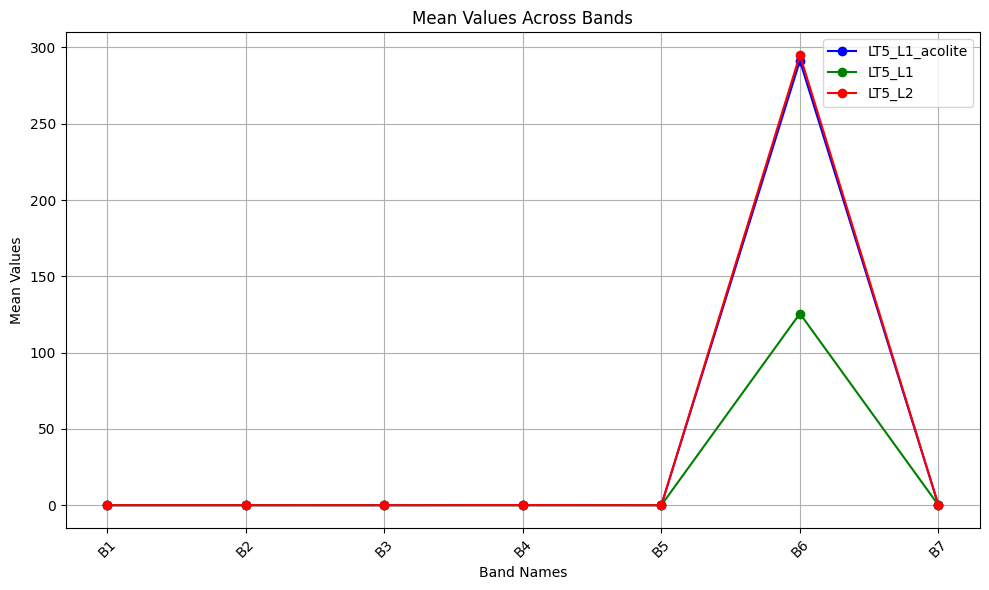

In [109]:
import matplotlib.pyplot as plt

# Define the column names representing the bands
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Initialize lists to store mean values for each band across the three dataframes
mean_values_LT5_L1_acolite = []
mean_values_LT5_L1 = []
mean_values_LT5_L2 = []

# Calculate mean values for each band across the three dataframes
for band in band_names:
    mean_LT5_L1_acolite = LT5_L1_acolite[band].mean()
    mean_LT5_L1 = LT5_L1[band].mean()
    mean_LT5_L2 = LT5_L2[band].mean()
    
    mean_values_LT5_L1_acolite.append(mean_LT5_L1_acolite)
    mean_values_LT5_L1.append(mean_LT5_L1)
    mean_values_LT5_L2.append(mean_LT5_L2)

# Plotting the line graph
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot mean values for each band across the three dataframes
plt.plot(band_names, mean_values_LT5_L1_acolite, marker='o', linestyle='-', color='b', label='LT5_L1_acolite')
plt.plot(band_names, mean_values_LT5_L1, marker='o', linestyle='-', color='g', label='LT5_L1')
plt.plot(band_names, mean_values_LT5_L2, marker='o', linestyle='-', color='r', label='LT5_L2')

# Add labels and title
plt.xlabel('Band Names')
plt.ylabel('Mean Values')
plt.title('Mean Values Across Bands')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid lines
plt.legend()  # Add legend

# Show plot
plt.tight_layout()  # Ensure all elements fit nicely in the figure
plt.show()


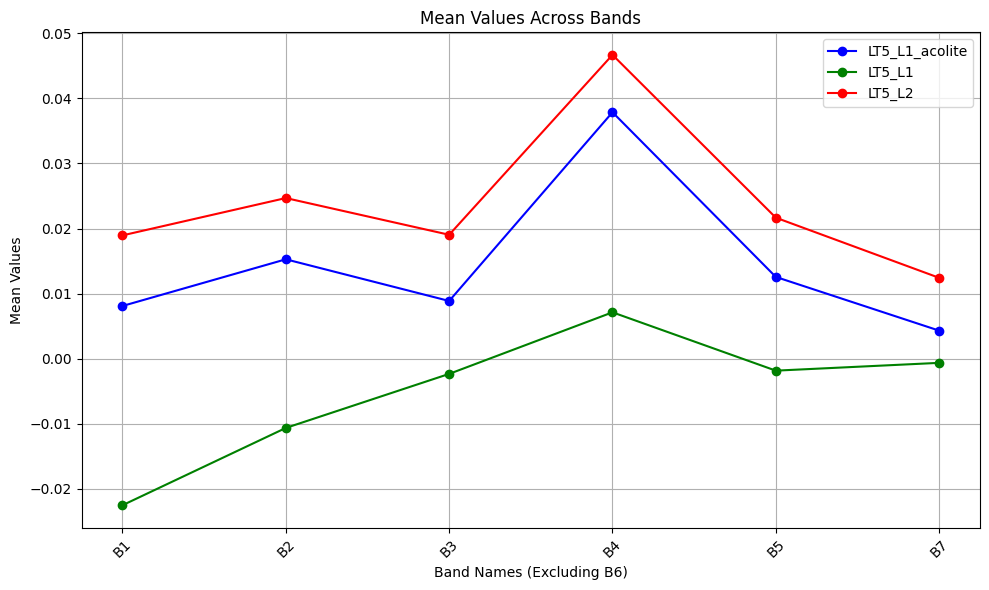

In [179]:
import matplotlib.pyplot as plt

# Assuming you have already generated the three DataFrames: LT5_L1_acolite, LT5_L1, LT5_L2

# Define the column names representing the bands (excluding B6)
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']

# Initialize lists to store mean values for each band across the three dataframes
mean_values_LT5_L1_acolite = []
mean_values_LT5_L1 = []
mean_values_LT5_L2 = []

# Calculate mean values for each band across the three dataframes (excluding B6)
for band in band_names:
    mean_LT5_L1_acolite = LT5_L1_acolite[band].mean()
    mean_LT5_L1 = LT5_L1[band].mean()
    mean_LT5_L2 = LT5_L2[band].mean()
    
    mean_values_LT5_L1_acolite.append(mean_LT5_L1_acolite)
    mean_values_LT5_L1.append(mean_LT5_L1)
    mean_values_LT5_L2.append(mean_LT5_L2)

# Plotting the line graph (excluding B6)
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot mean values for each band across the three dataframes (excluding B6)
plt.plot(band_names, mean_values_LT5_L1_acolite, marker='o', linestyle='-', color='b', label='LT5_L1_acolite')
plt.plot(band_names, mean_values_LT5_L1, marker='o', linestyle='-', color='g', label='LT5_L1')
plt.plot(band_names, mean_values_LT5_L2, marker='o', linestyle='-', color='r', label='LT5_L2')

# Add labels and title
plt.xlabel('Band Names (Excluding B6)')
plt.ylabel('Mean Values')
plt.title('Mean Values Across Bands')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid lines
plt.legend()  # Add legend

# Show plot
plt.tight_layout()  # Ensure all elements fit nicely in the figure
plt.show()


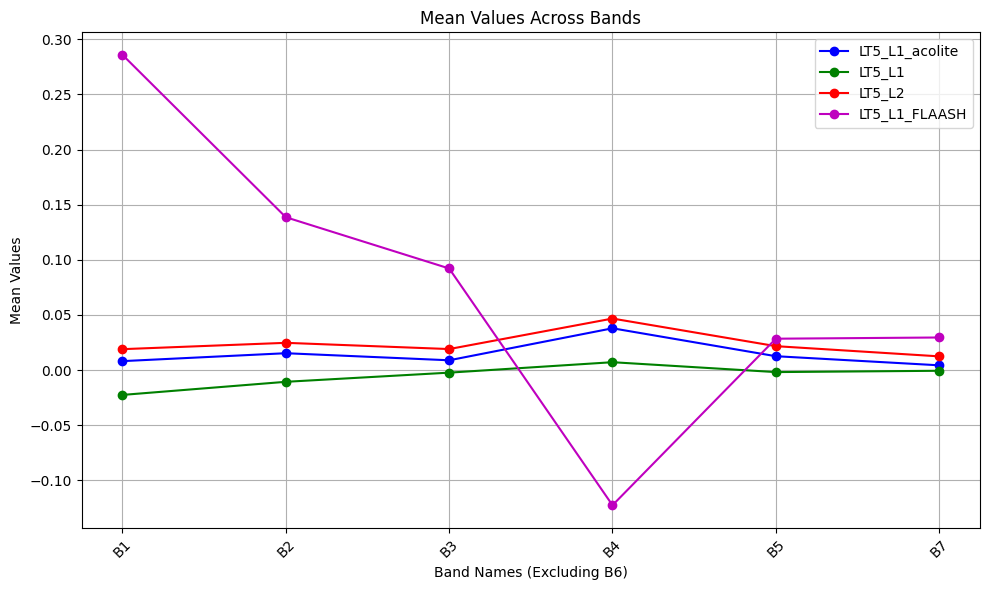

In [250]:
import matplotlib.pyplot as plt

# Assuming you have already generated the four DataFrames: LT5_L1_acolite, LT5_L1, LT5_L2, LT5_L1_FLAASH

# Define the column names representing the bands (excluding B6)
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']

# Initialize lists to store mean values for each band across the four dataframes
mean_values_LT5_L1_acolite = []
mean_values_LT5_L1 = []
mean_values_LT5_L2 = []
mean_values_LT5_L1_FLAASH = []

# Calculate mean values for each band across the four dataframes (excluding B6)
for band in band_names:
    mean_LT5_L1_acolite = LT5_L1_acolite[band].mean()
    mean_LT5_L1 = LT5_L1[band].mean()
    mean_LT5_L2 = LT5_L2[band].mean()
    mean_LT5_L1_FLAASH = LT5_L1_FLAASH[band].mean()
    
    mean_values_LT5_L1_acolite.append(mean_LT5_L1_acolite)
    mean_values_LT5_L1.append(mean_LT5_L1)
    mean_values_LT5_L2.append(mean_LT5_L2)
    mean_values_LT5_L1_FLAASH.append(mean_LT5_L1_FLAASH)

# Plotting the line graph (excluding B6)
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot mean values for each band across the four dataframes (excluding B6)
plt.plot(band_names, mean_values_LT5_L1_acolite, marker='o', linestyle='-', color='b', label='LT5_L1_acolite')
plt.plot(band_names, mean_values_LT5_L1, marker='o', linestyle='-', color='g', label='LT5_L1')
plt.plot(band_names, mean_values_LT5_L2, marker='o', linestyle='-', color='r', label='LT5_L2')
plt.plot(band_names, mean_values_LT5_L1_FLAASH, marker='o', linestyle='-', color='m', label='LT5_L1_FLAASH')

# Add labels and title
plt.xlabel('Band Names (Excluding B6)')
plt.ylabel('Mean Values')
plt.title('Mean Values Across Bands')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid lines
plt.legend()  # Add legend

# Show plot
plt.tight_layout()  # Ensure all elements fit nicely in the figure
plt.show()


In [111]:
import pandas as pd

# # Ensure the indices are the same
# LT5_L1_acolite.reset_index(drop=True, inplace=True)
# LT5_L2.reset_index(drop=True, inplace=True)

# Merge the two dataframes on 'row' and 'col'
merged_df = pd.merge(LT5_L1_acolite, LT5_L2, on=['row', 'col'], suffixes=('_L1_acolite', '_L2'))

# List of bands to compute the difference for
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Calculate the differences
differences = pd.DataFrame()
differences['row'] = merged_df['row']
differences['col'] = merged_df['col']

# LT5_L1_acolite - LT5_L2
for band in bands:
    differences[band] = merged_df[f'{band}_L2'] - merged_df[f'{band}_L1_acolite']

# Display the result
differences

,row,col,B1,B2,B3,B4,B5,B6,B7
0,1208,6078,0.005584,0.003021,0.003146,0.003814,0.001784,4.613219,0.001365
1,1208,6079,0.023054,0.023620,0.025371,0.027194,0.025616,4.837472,0.022970
2,1208,6080,0.005550,0.003012,0.003108,0.004003,0.001705,4.909593,0.001447
3,1209,6076,0.005561,0.003030,0.003154,0.004187,0.001711,4.383747,0.001410
4,1209,6077,0.014577,0.013641,0.014564,0.015176,0.014200,4.626427,0.012465
...,...,...,...,...,...,...,...,...,...
5268,1327,5903,0.025683,0.026820,0.028935,0.030774,0.029584,4.347363,0.026462
5269,1327,5904,0.025652,0.026817,0.028949,0.031425,0.029573,4.361035,0.026462
5270,1327,5905,0.005636,0.003215,0.003460,0.004789,0.001952,4.499960,0.001575
5271,1327,5906,0.005636,0.003226,0.003520,0.005466,0.001840,4.626891,0.001596


# MAPPING (Using Earth Engine Assets)

## LT5_L1

### Combination: B1, B2, B3 (Blue, Green, Red)

In [243]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B1'
LT05_L1_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B2'
LT05_L1_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_b1_ee = ee.Image(LT05_L1_b1_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_b2_ee = ee.Image(LT05_L1_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_b3_ee = ee.Image(LT05_L1_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Clip images to the shapefile area
LT05_L1_b1_clipped = LT05_L1_b1_ee.clip(shp_ee)
LT05_L1_b2_clipped = LT05_L1_b2_ee.clip(shp_ee)
LT05_L1_b3_clipped = LT05_L1_b3_ee.clip(shp_ee)

# # Apply masks to filter out values greater than 230 for each band
# mask_b1 = LT05_L1_b1_clipped.lte(230)
# mask_b2 = LT05_L1_b2_clipped.lte(230)
# mask_b3 = LT05_L1_b3_clipped.lte(230)
# LT05_L1_b1_clipped = LT05_L1_b1_clipped.updateMask(mask_b1)
# LT05_L1_b2_clipped = LT05_L1_b2_clipped.updateMask(mask_b2)
# LT05_L1_b3_clipped = LT05_L1_b3_clipped.updateMask(mask_b3)

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3', 'B2', 'B1'],
  'min': 0,
  'max': 30,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L1_b3_clipped, LT05_L1_b2_clipped, LT05_L1_b1_clipped]).visualize(**rgb_vis)

# # Mask out pixels with values greater than 230
# mask = rgb_image.lte(230)
# rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L1_b1_clipped, {'min': 0, 'max': 90, 'palette': ['blue', 'green', 'red']}, 'B1 (Clipped)')
# Map.addLayer(LT05_L1_b2_clipped, {'min': 0, 'max': 90, 'palette': ['blue', 'green', 'red']}, 'B2 (Clipped)')
# Map.addLayer(LT05_L1_b3_clipped, {'min': 0, 'max': 90, 'palette': ['blue', 'green', 'red']}, 'B3 (Clipped)')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Clipped)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [232]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths for Landsat 5 Collection 2
LT05_L1_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B1'
LT05_L1_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B2'
LT05_L1_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_b1_ee = ee.Image(LT05_L1_b1_asset).rename(['B1'])  # Rename band 'B1'
LT05_L1_b2_ee = ee.Image(LT05_L1_b2_asset).rename(['B2'])  # Rename band 'B2'
LT05_L1_b3_ee = ee.Image(LT05_L1_b3_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area
LT05_L1_b1_clipped = LT05_L1_b1_ee.clip(shp_ee)
LT05_L1_b2_clipped = LT05_L1_b2_ee.clip(shp_ee)
LT05_L1_b3_clipped = LT05_L1_b3_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L1_b1_scaled = LT05_L1_b1_clipped.multiply(0.0001810338).add(-0.02982)
LT05_L1_b2_scaled = LT05_L1_b2_clipped.multiply(0.0001840138).add(-0.01518)
LT05_L1_b3_scaled = LT05_L1_b3_clipped.multiply(0.0002071548).add(-0.00525)

# Create RGB composite visualization using B1, B2, B3
rgb_vis = {
    'bands': ['B3', 'B2', 'B1'],
    'min': 0,
    'max': 0.0005,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L1_b3_scaled, LT05_L1_b2_scaled, LT05_L1_b1_scaled]).visualize(**rgb_vis)

# # Mask out pixels with values greater than 230
# mask = rgb_image.lte(230)
# rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# Add each band as a separate layer with a color palette
Map.addLayer(LT05_L1_b1_scaled, {'min': 0, 'max': -0.009906282000000002, 'palette': ['blue', 'green', 'red']}, 'B1 (Scaled)')
Map.addLayer(LT05_L1_b2_scaled, {'min': 0, 'max': -0.006163323800000002, 'palette': ['blue', 'green', 'red']}, 'B2 (Scaled)')
Map.addLayer(LT05_L1_b3_scaled, {'min': 0, 'max': 0.0053148948, 'palette': ['blue', 'green', 'red']}, 'B3 (Scaled)')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Clipped & Scaled)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [122]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths for Landsat 5 Collection 2
LT05_L1_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B1'
LT05_L1_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B2'
LT05_L1_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_b1_ee = ee.Image(LT05_L1_b1_asset).rename(['B1'])  # Rename band 'B1'
LT05_L1_b2_ee = ee.Image(LT05_L1_b2_asset).rename(['B2'])  # Rename band 'B2'
LT05_L1_b3_ee = ee.Image(LT05_L1_b3_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area
LT05_L1_b1_clipped = LT05_L1_b1_ee.clip(shp_ee)
LT05_L1_b2_clipped = LT05_L1_b2_ee.clip(shp_ee)
LT05_L1_b3_clipped = LT05_L1_b3_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L1_b1_scaled = LT05_L1_b1_clipped.multiply(0.0001810338).add(-0.02982)
LT05_L1_b2_scaled = LT05_L1_b2_clipped.multiply(0.0001840138).add(-0.01518)
LT05_L1_b3_scaled = LT05_L1_b3_clipped.multiply(0.0002071548).add(-0.00525)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
LT05_L1_max_b1 = calculate_max(LT05_L1_b1_scaled, 'B1')
LT05_L1_max_b2 = calculate_max(LT05_L1_b2_scaled, 'B2')
LT05_L1_max_b3 = calculate_max(LT05_L1_b3_scaled, 'B3')

# Print the results
print('Maximum value for B1:', LT05_L1_max_b1.getInfo())
print('Maximum value for B2:', LT05_L1_max_b2.getInfo())
print('Maximum value for B3:', LT05_L1_max_b3.getInfo())

Maximum value for B1: -0.009906282000000002
Maximum value for B2: -0.006163323800000002
Maximum value for B3: 0.0053148948


### Combination: B2, B3, B4 (Green, Red, Near Infrared)

In [244]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B2'
LT05_L1_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B3'
LT05_L1_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_b2_ee = ee.Image(LT05_L1_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_b3_ee = ee.Image(LT05_L1_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_b4_ee = ee.Image(LT05_L1_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L1_b2_clipped = LT05_L1_b2_ee.clip(shp_ee)
LT05_L1_b3_clipped = LT05_L1_b3_ee.clip(shp_ee)
LT05_L1_b4_clipped = LT05_L1_b4_ee.clip(shp_ee)

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 30,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([LT05_L1_b4_clipped, LT05_L1_b3_clipped, LT05_L1_b2_clipped]).visualize(**B2_B3_B4_vis)

# Mask out pixels with values greater than 230
mask = B2_B3_B4_image.lte(230)
B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L1_b2_clipped, {'min': 0, 'max': 50, 'palette': ['blue', 'green', 'red']}, 'B2 (Clipped)')
# Map.addLayer(LT05_L1_b3_clipped, {'min': 0, 'max': 50, 'palette': ['blue', 'green', 'red']}, 'B3 (Clipped)')
# Map.addLayer(LT05_L1_b4_clipped, {'min': 0, 'max': 50, 'palette': ['blue', 'green', 'red']}, 'B4 (Clipped)')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2, B3, B4 (Clipped)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [224]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B2'
LT05_L1_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B3'
LT05_L1_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_b2_ee = ee.Image(LT05_L1_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_b3_ee = ee.Image(LT05_L1_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_b4_ee = ee.Image(LT05_L1_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L1_b2_clipped = LT05_L1_b2_ee.clip(shp_ee)
LT05_L1_b3_clipped = LT05_L1_b3_ee.clip(shp_ee)
LT05_L1_b4_clipped = LT05_L1_b4_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L1_b2_scaled = LT05_L1_b2_clipped.multiply(0.0001840138).add(-0.01518)
LT05_L1_b3_scaled = LT05_L1_b3_clipped.multiply(0.0002071548).add(-0.00525)
LT05_L1_b4_scaled = LT05_L1_b4_clipped.multiply(0.0002290102).add(0.00399)

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.01,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([LT05_L1_b4_scaled, LT05_L1_b3_scaled, LT05_L1_b2_scaled]).visualize(**B2_B3_B4_vis)

# Mask out pixels with values greater than 230
mask = B2_B3_B4_image.lte(230)
B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L1_b2_scaled, {'min': 0, 'max': -0.006163323800000002}, 'B2 (Scaled)')
# Map.addLayer(LT05_L1_b3_scaled, {'min': 0, 'max': 0.0053148948}, 'B3 (Scaled)')
# Map.addLayer(LT05_L1_b4_scaled, {'min': 0, 'max': 0.0229978466}, 'B4 (Scaled)')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2, B3, B4 (Clipped & Scaled)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [125]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B2'
LT05_L1_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B3'
LT05_L1_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_b2_ee = ee.Image(LT05_L1_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_b3_ee = ee.Image(LT05_L1_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_b4_ee = ee.Image(LT05_L1_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L1_b2_clipped = LT05_L1_b2_ee.clip(shp_ee)
LT05_L1_b3_clipped = LT05_L1_b3_ee.clip(shp_ee)
LT05_L1_b4_clipped = LT05_L1_b4_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L1_b2_scaled = LT05_L1_b2_clipped.multiply(0.0001840138).add(-0.01518)
LT05_L1_b3_scaled = LT05_L1_b3_clipped.multiply(0.0002071548).add(-0.00525)
LT05_L1_b4_scaled = LT05_L1_b4_clipped.multiply(0.0002290102).add(0.00399)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
LT05_L1_max_b2 = calculate_max(LT05_L1_b2_scaled, 'B2')
LT05_L1_max_b3 = calculate_max(LT05_L1_b3_scaled, 'B3')
LT05_L1_max_b4 = calculate_max(LT05_L1_b4_scaled, 'B4')

# Print the results
print('Maximum value for B2:', LT05_L1_max_b2.getInfo())
print('Maximum value for B3:', LT05_L1_max_b3.getInfo())
print('Maximum value for B4:', LT05_L1_max_b4.getInfo())


Maximum value for B2: -0.006163323800000002
Maximum value for B3: 0.0053148948
Maximum value for B4: 0.0229978466


## LT5_L1_acolite

### Combination: B1, B2, B3 (Blue, Green, Red)

In [223]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_acolite_b1_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_486_SRB1'
LT05_L1_acolite_b2_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2'
LT05_L1_acolite_b3_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_acolite_b1_ee = ee.Image(LT05_L1_acolite_b1_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_acolite_b2_ee = ee.Image(LT05_L1_acolite_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_acolite_b3_ee = ee.Image(LT05_L1_acolite_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Clip images to the shapefile area
LT05_L1_acolite_b1_clipped = LT05_L1_acolite_b1_ee.clip(shp_ee)
LT05_L1_acolite_b2_clipped = LT05_L1_acolite_b2_ee.clip(shp_ee)
LT05_L1_acolite_b3_clipped = LT05_L1_acolite_b3_ee.clip(shp_ee)

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3', 'B2', 'B1'],
  'min': 0,
  'max': 0.05,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L1_acolite_b3_clipped, LT05_L1_acolite_b2_clipped, LT05_L1_acolite_b1_clipped]).visualize(**rgb_vis)

# Mask out pixels with values greater than 230
mask = rgb_image.lte(230)
rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L1_acolite_b1_clipped, {'min': 0, 'max': 0.11242344230413437, 'palette': ['blue', 'green', 'red']}, 'B1 (Clipped)')
# Map.addLayer(LT05_L1_acolite_b2_clipped, {'min': 0, 'max': 0.1305348426103592, 'palette': ['blue', 'green', 'red']}, 'B2 (Clipped)')
# Map.addLayer(LT05_L1_acolite_b3_clipped, {'min': 0, 'max': 0.12283462285995483, 'palette': ['blue', 'green', 'red']}, 'B3 (Clipped)')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Clipped)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [127]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_acolite_b1_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_486_SRB1'
LT05_L1_acolite_b2_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2'
LT05_L1_acolite_b3_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_acolite_b1_ee = ee.Image(LT05_L1_acolite_b1_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_acolite_b2_ee = ee.Image(LT05_L1_acolite_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_acolite_b3_ee = ee.Image(LT05_L1_acolite_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Clip images to the shapefile area
LT05_L1_acolite_b1_clipped = LT05_L1_acolite_b1_ee.clip(shp_ee)
LT05_L1_acolite_b2_clipped = LT05_L1_acolite_b2_ee.clip(shp_ee)
LT05_L1_acolite_b3_clipped = LT05_L1_acolite_b3_ee.clip(shp_ee)

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3', 'B2', 'B1'],
  'min': 0,
  'max': 80,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L1_acolite_b3_clipped, LT05_L1_acolite_b2_clipped, LT05_L1_acolite_b1_clipped]).visualize(**rgb_vis)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
LT05_L1_acolite_max_b1 = calculate_max(LT05_L1_acolite_b1_clipped, 'B1')
LT05_L1_acolite_max_b2 = calculate_max(LT05_L1_acolite_b2_clipped, 'B2')
LT05_L1_acolite_max_b3 = calculate_max(LT05_L1_acolite_b3_clipped, 'B3')

# Print the results
print('Maximum value for B1:', LT05_L1_acolite_max_b1.getInfo())
print('Maximum value for B2:', LT05_L1_acolite_max_b2.getInfo())
print('Maximum value for B3:', LT05_L1_acolite_max_b3.getInfo())

Maximum value for B1: 0.11242344230413437
Maximum value for B2: 0.1305348426103592
Maximum value for B3: 0.12283462285995483


### Combination: B2, B3, B4 (Green, Red, Near Infrared)

In [222]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_acolite_b2_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2'
LT05_L1_acolite_b3_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3'
LT05_L1_acolite_b4_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_839_SRB4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_acolite_b2_ee = ee.Image(LT05_L1_acolite_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_acolite_b3_ee = ee.Image(LT05_L1_acolite_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_acolite_b4_ee = ee.Image(LT05_L1_acolite_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L1_acolite_b2_clipped = LT05_L1_acolite_b2_ee.clip(shp_ee)
LT05_L1_acolite_b3_clipped = LT05_L1_acolite_b3_ee.clip(shp_ee)
LT05_L1_acolite_b4_clipped = LT05_L1_acolite_b4_ee.clip(shp_ee)

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.05,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([LT05_L1_acolite_b4_clipped, LT05_L1_acolite_b3_clipped, LT05_L1_acolite_b2_clipped]).visualize(**B2_B3_B4_vis)

# Mask out pixels with values greater than 230
mask = B2_B3_B4_image.lte(230)
B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L1_acolite_b2_clipped, {'min': 0, 'max': 0.1305348426103592, 'palette': ['blue', 'green', 'red']}, 'B2 (Clipped)')
# Map.addLayer(LT05_L1_acolite_b3_clipped, {'min': 0, 'max': 0.12283462285995483, 'palette': ['blue', 'green', 'red']}, 'B3 (Clipped)')
# Map.addLayer(LT05_L1_acolite_b4_clipped, {'min': 0, 'max': 0.3050469160079956, 'palette': ['blue', 'green', 'red']}, 'B4 (Clipped)')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2, B3, B4 (Clipped)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [129]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_acolite_b2_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2'
LT05_L1_acolite_b3_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3'
LT05_L1_acolite_b4_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_839_SRB4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_acolite_b2_ee = ee.Image(LT05_L1_acolite_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_acolite_b3_ee = ee.Image(LT05_L1_acolite_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_acolite_b4_ee = ee.Image(LT05_L1_acolite_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L1_acolite_b2_clipped = LT05_L1_acolite_b2_ee.clip(shp_ee)
LT05_L1_acolite_b3_clipped = LT05_L1_acolite_b3_ee.clip(shp_ee)
LT05_L1_acolite_b4_clipped = LT05_L1_acolite_b4_ee.clip(shp_ee)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
LT05_L1_max_b2 = calculate_max(LT05_L1_acolite_b2_clipped, 'B2')
LT05_L1_max_b3 = calculate_max(LT05_L1_acolite_b3_clipped, 'B3')
LT05_L1_max_b4 = calculate_max(LT05_L1_acolite_b4_clipped, 'B4')

# Print the results
print('Maximum value for B2:', LT05_L1_max_b2.getInfo())
print('Maximum value for B3:', LT05_L1_max_b3.getInfo())
print('Maximum value for B4:', LT05_L1_max_b4.getInfo())

Maximum value for B2: 0.1305348426103592
Maximum value for B3: 0.12283462285995483
Maximum value for B4: 0.3050469160079956


## LT5_L2

### Combination: B1, B2, B3 (Blue, Green, Red)

In [253]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths for Landsat 5 Collection 2
LT05_L2_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B1'
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L2_b1_ee = ee.Image(LT05_L2_b1_asset).rename(['B1'])  # Rename band 'B1'
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B2'])  # Rename band 'B2'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area
LT05_L2_b1_clipped = LT05_L2_b1_ee.clip(shp_ee)
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L2_b1_scaled = LT05_L2_b1_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)

# Create RGB composite visualization using B1, B2, B3
rgb_vis = {
    'bands': ['B3', 'B2', 'B1'],
    'min': 0,
    'max': 0.05,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L2_b3_scaled, LT05_L2_b2_scaled, LT05_L2_b1_scaled]).visualize(**rgb_vis)

# Mask out pixels with values greater than 230
mask = rgb_image.lte(230)
rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# Add each band as a separate layer with a color palette
Map.addLayer(LT05_L2_b1_scaled, {'min': 0, 'max': 0.11817499999999997, 'palette': ['blue', 'green', 'red']}, 'B1 (Scaled)')
Map.addLayer(LT05_L2_b2_scaled, {'min': 0, 'max': 0.1338225, 'palette': ['blue', 'green', 'red']}, 'B2 (Scaled)')
Map.addLayer(LT05_L2_b3_scaled, {'min': 0, 'max': 0.126865, 'palette': ['blue', 'green', 'red']}, 'B3 (Scaled)')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Clipped & Scaled)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [131]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths for Landsat 5 Collection 2
LT05_L2_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B1'
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L2_b1_ee = ee.Image(LT05_L2_b1_asset).rename(['B1'])  # Rename band 'B1'
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B2'])  # Rename band 'B2'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area
LT05_L2_b1_clipped = LT05_L2_b1_ee.clip(shp_ee)
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L2_b1_scaled = LT05_L2_b1_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
max_b1 = calculate_max(LT05_L2_b1_scaled, 'B1')
max_b2 = calculate_max(LT05_L2_b2_scaled, 'B2')
max_b3 = calculate_max(LT05_L2_b3_scaled, 'B3')

# Print the results
print('Maximum value for B1:', max_b1.getInfo())
print('Maximum value for B2:', max_b2.getInfo())
print('Maximum value for B3:', max_b3.getInfo())

Maximum value for B1: 0.11817499999999997
Maximum value for B2: 0.1338225
Maximum value for B3: 0.126865


### Combination: B2, B3, B4 (Green, Red, Near Infrared)

In [220]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'
LT05_L2_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L2_b4_ee = ee.Image(LT05_L2_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)
LT05_L2_b4_clipped = LT05_L2_b4_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b4_scaled = LT05_L2_b4_clipped.multiply(0.0000275).add(-0.2)

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.05,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([LT05_L2_b4_scaled, LT05_L2_b3_scaled, LT05_L2_b2_scaled]).visualize(**B2_B3_B4_vis)

# Mask out pixels with values greater than 230
mask = B2_B3_B4_image.lte(230)
B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L2_b2_scaled, {'min': 0, 'max': 0.1338225}, 'B2 (Scaled)')
# Map.addLayer(LT05_L2_b3_scaled, {'min': 0, 'max': 0.126865}, 'B3 (Scaled)')
# Map.addLayer(LT05_L2_b4_scaled, {'min': 0, 'max': 0.28097500000000003}, 'B4 (Scaled)')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2. B3, B4 (Clipped & Scaled)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [133]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'
LT05_L2_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L2_b4_ee = ee.Image(LT05_L2_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)
LT05_L2_b4_clipped = LT05_L2_b4_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b4_scaled = LT05_L2_b4_clipped.multiply(0.0000275).add(-0.2)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
max_b2 = calculate_max(LT05_L2_b2_scaled, 'B2')
max_b3 = calculate_max(LT05_L2_b3_scaled, 'B3')
max_b4 = calculate_max(LT05_L2_b4_scaled, 'B4')

# Print the results
print('Maximum value for B2:', max_b2.getInfo())
print('Maximum value for B3:', max_b3.getInfo())
print('Maximum value for B4:', max_b4.getInfo())

Maximum value for B2: 0.1338225
Maximum value for B3: 0.126865
Maximum value for B4: 0.28097500000000003


## FLAASH

### Combination: B1, B2, B3 (Blue, Green, Red)

In [255]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_FLAASH_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B1'
LT05_L1_FLAASH_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B2'
LT05_L1_FLAASH_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_FLAASH_b1_ee = ee.Image(LT05_L1_FLAASH_b1_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_FLAASH_b2_ee = ee.Image(LT05_L1_FLAASH_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_FLAASH_b3_ee = ee.Image(LT05_L1_FLAASH_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Divide each band's values by 10,000
LT05_L1_FLAASH_b1_ee = LT05_L1_FLAASH_b1_ee.divide(32768)
LT05_L1_FLAASH_b2_ee = LT05_L1_FLAASH_b2_ee.divide(32768)
LT05_L1_FLAASH_b3_ee = LT05_L1_FLAASH_b3_ee.divide(32768)

# # Apply the scaling method to each band
# def scale_band(image):
#     return image.add(32768).divide(65535)

# LT05_L1_FLAASH_b1_ee = scale_band(LT05_L1_FLAASH_b1_ee)
# LT05_L1_FLAASH_b2_ee = scale_band(LT05_L1_FLAASH_b2_ee)
# LT05_L1_FLAASH_b3_ee = scale_band(LT05_L1_FLAASH_b3_ee)

# Clip images to the shapefile area
LT05_L1_FLAASH_b1_clipped = LT05_L1_FLAASH_b1_ee.clip(shp_ee)
LT05_L1_FLAASH_b2_clipped = LT05_L1_FLAASH_b2_ee.clip(shp_ee)
LT05_L1_FLAASH_b3_clipped = LT05_L1_FLAASH_b3_ee.clip(shp_ee)

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3', 'B2', 'B1'],
  'min': 0,
  'max': 0.1,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L1_FLAASH_b3_clipped, LT05_L1_FLAASH_b2_clipped, LT05_L1_FLAASH_b1_clipped]).visualize(**rgb_vis)

# Mask out pixels with values greater than 230
mask = rgb_image.lte(230)
rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# Add each band as a separate layer
Map.addLayer(LT05_L1_FLAASH_b1_clipped, {'min': 0, 'max': 3, 'palette': ['blue', 'green', 'red']}, 'B1 (Clipped)')
Map.addLayer(LT05_L1_FLAASH_b2_clipped, {'min': 0, 'max': 3, 'palette': ['blue', 'green', 'red']}, 'B2 (Clipped)')
Map.addLayer(LT05_L1_FLAASH_b3_clipped, {'min': 0, 'max': 3, 'palette': ['blue', 'green', 'red']}, 'B3 (Clipped)')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Clipped)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [187]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_FLAASH_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B1'
LT05_L1_FLAASH_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B2'
LT05_L1_FLAASH_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_FLAASH_b1_ee = ee.Image(LT05_L1_FLAASH_b1_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_FLAASH_b2_ee = ee.Image(LT05_L1_FLAASH_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_FLAASH_b3_ee = ee.Image(LT05_L1_FLAASH_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Divide each band's values by 10,000
LT05_L1_FLAASH_b1_ee = LT05_L1_FLAASH_b1_ee.divide(10000)
LT05_L1_FLAASH_b2_ee = LT05_L1_FLAASH_b2_ee.divide(10000)
LT05_L1_FLAASH_b3_ee = LT05_L1_FLAASH_b3_ee.divide(10000)

# # Apply the scaling method to each band
# def scale_band(image):
#     return image.add(32768).divide(65535)

# LT05_L1_FLAASH_b1_ee = scale_band(LT05_L1_FLAASH_b1_ee)
# LT05_L1_FLAASH_b2_ee = scale_band(LT05_L1_FLAASH_b2_ee)
# LT05_L1_FLAASH_b3_ee = scale_band(LT05_L1_FLAASH_b3_ee)

# Clip images to the shapefile area
LT05_L1_FLAASH_b1_clipped = LT05_L1_FLAASH_b1_ee.clip(shp_ee)
LT05_L1_FLAASH_b2_clipped = LT05_L1_FLAASH_b2_ee.clip(shp_ee)
LT05_L1_FLAASH_b3_clipped = LT05_L1_FLAASH_b3_ee.clip(shp_ee)

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3', 'B2', 'B1'],
  'min': 0,
  'max': 80,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([LT05_L1_FLAASH_b3_clipped, LT05_L1_FLAASH_b2_clipped, LT05_L1_FLAASH_b1_clipped]).visualize(**rgb_vis)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
LT05_L1_FLAASH_max_b1 = calculate_max(LT05_L1_FLAASH_b1_clipped, 'B1')
LT05_L1_FLAASH_max_b2 = calculate_max(LT05_L1_FLAASH_b2_clipped, 'B2')
LT05_L1_FLAASH_max_b3 = calculate_max(LT05_L1_FLAASH_b3_clipped, 'B3')

# Print the results
print('Maximum value for B1:', LT05_L1_FLAASH_max_b1.getInfo())
print('Maximum value for B2:', LT05_L1_FLAASH_max_b2.getInfo())
print('Maximum value for B3:', LT05_L1_FLAASH_max_b3.getInfo())

Maximum value for B1: 3.2027
Maximum value for B2: 3.0698
Maximum value for B3: 3.0099


### Combination: B2, B3, B4 (Green, Red, Near Infrared)

In [247]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_FLAASH_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B2'
LT05_L1_FLAASH_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B3'
LT05_L1_FLAASH_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_FLAASH_b2_ee = ee.Image(LT05_L1_FLAASH_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_FLAASH_b3_ee = ee.Image(LT05_L1_FLAASH_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_FLAASH_b4_ee = ee.Image(LT05_L1_FLAASH_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Divide each band's values by 10,000
LT05_L1_FLAASH_b2_ee = LT05_L1_FLAASH_b2_ee.divide(10000)
LT05_L1_FLAASH_b3_ee = LT05_L1_FLAASH_b3_ee.divide(10000)
LT05_L1_FLAASH_b4_ee = LT05_L1_FLAASH_b4_ee.divide(10000)

# Clip images to the shapefile area
LT05_L1_FLAASH_b2_clipped = LT05_L1_FLAASH_b2_ee.clip(shp_ee)
LT05_L1_FLAASH_b3_clipped = LT05_L1_FLAASH_b3_ee.clip(shp_ee)
LT05_L1_FLAASH_b4_clipped = LT05_L1_FLAASH_b4_ee.clip(shp_ee)

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 1,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([LT05_L1_FLAASH_b4_clipped, LT05_L1_FLAASH_b3_clipped, LT05_L1_FLAASH_b2_clipped]).visualize(**B2_B3_B4_vis)

# Mask out pixels with values greater than 230
mask = B2_B3_B4_image.lte(230)
B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band as a separate layer
# Map.addLayer(LT05_L1_FLAASH_b2_clipped, {'min': 0, 'max': 30698, 'palette': ['blue', 'green', 'red']}, 'B2 (Clipped)')
# Map.addLayer(LT05_L1_FLAASH_b3_clipped, {'min': 0, 'max': 30099, 'palette': ['blue', 'green', 'red']}, 'B3 (Clipped)')
# Map.addLayer(LT05_L1_FLAASH_b4_clipped, {'min': 0, 'max': 29113, 'palette': ['blue', 'green', 'red']}, 'B4 (Clipped)')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2, B3, B4 (Clipped)')

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

In [141]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths
LT05_L1_FLAASH_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B2'
LT05_L1_FLAASH_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B3'
LT05_L1_FLAASH_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands
LT05_L1_FLAASH_b2_ee = ee.Image(LT05_L1_FLAASH_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_FLAASH_b3_ee = ee.Image(LT05_L1_FLAASH_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'
LT05_L1_FLAASH_b4_ee = ee.Image(LT05_L1_FLAASH_b4_asset).rename(['B4'])  # Rename band 'b1' to 'B4'

# Clip images to the shapefile area
LT05_L1_FLAASH_b2_clipped = LT05_L1_FLAASH_b2_ee.clip(shp_ee)
LT05_L1_FLAASH_b3_clipped = LT05_L1_FLAASH_b3_ee.clip(shp_ee)
LT05_L1_FLAASH_b4_clipped = LT05_L1_FLAASH_b4_ee.clip(shp_ee)

# Define a function to calculate the maximum value for a band
def calculate_max(image, band_name):
    max_value = image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=shp_ee.geometry(),
        scale=30  # Adjust scale as needed, 30 meters is a common scale for Landsat imagery
    ).get(band_name)
    return max_value

# Calculate maximum values for each band
LT05_L1_max_b2 = calculate_max(LT05_L1_FLAASH_b2_clipped, 'B2')
LT05_L1_max_b3 = calculate_max(LT05_L1_FLAASH_b3_clipped, 'B3')
LT05_L1_max_b4 = calculate_max(LT05_L1_FLAASH_b4_clipped, 'B4')

# Print the results
print('Maximum value for B2:', LT05_L1_max_b2.getInfo())
print('Maximum value for B3:', LT05_L1_max_b3.getInfo())
print('Maximum value for B4:', LT05_L1_max_b4.getInfo())

Maximum value for B2: 30698
Maximum value for B3: 30099
Maximum value for B4: 29113


# Difference in Maps

## RGB (L2 - Acolite)

In [256]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Apply the cloud masking function

# Define Earth Engine asset paths for the first dataset (acolite)
LT05_L1_acolite_b1_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_486_SRB1'
LT05_L1_acolite_b2_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2'
LT05_L1_acolite_b3_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3'

# Define Earth Engine asset paths for the second dataset (Landsat 5 Collection 2)
LT05_L2_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B1'
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands for acolite
LT05_L1_acolite_b1_ee = ee.Image(LT05_L1_acolite_b1_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_acolite_b2_ee = ee.Image(LT05_L1_acolite_b2_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_acolite_b3_ee = ee.Image(LT05_L1_acolite_b3_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Clip images to the shapefile area for acolite
LT05_L1_acolite_b1_clipped = LT05_L1_acolite_b1_ee.clip(shp_ee)
LT05_L1_acolite_b2_clipped = LT05_L1_acolite_b2_ee.clip(shp_ee)
LT05_L1_acolite_b3_clipped = LT05_L1_acolite_b3_ee.clip(shp_ee)

# Load TIFF images as EE Images from assets and rename bands for Landsat 5 Collection 2
LT05_L2_b1_ee = ee.Image(LT05_L2_b1_asset).rename(['B1'])  # Rename band 'B1'
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B2'])  # Rename band 'B2'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area for Landsat 5 Collection 2
LT05_L2_b1_clipped = LT05_L2_b1_ee.clip(shp_ee)
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance for Landsat 5 Collection 2
LT05_L2_b1_scaled = LT05_L2_b1_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)

# Calculate differences between corresponding bands l2 - acolite
diff_b1 = LT05_L2_b1_scaled.subtract(LT05_L1_acolite_b1_clipped).rename(['B1_Diff'])
diff_b2 = LT05_L2_b2_scaled.subtract(LT05_L1_acolite_b2_clipped).rename(['B2_Diff'])
diff_b3 = LT05_L2_b3_scaled.subtract(LT05_L1_acolite_b3_clipped).rename(['B3_Diff'])

# # Calculate differences between corresponding bands; acolite - L2
# diff_b1 = LT05_L1_acolite_b1_clipped.subtract(LT05_L2_b1_scaled).rename(['B1_Diff'])
# diff_b2 = LT05_L1_acolite_b2_clipped.subtract(LT05_L2_b2_scaled).rename(['B2_Diff'])
# diff_b3 = LT05_L1_acolite_b3_clipped.subtract(LT05_L2_b3_scaled).rename(['B3_Diff'])

# Create visualization parameters for differences
diff_vis_params = {
    'min': -0.05,
    'max': 0.05,
    'palette': ['red', 'green', 'blue']
}

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3_Diff', 'B2_Diff', 'B1_Diff'],
  'min': 0,
  'max': 0.05,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([diff_b3, diff_b2, diff_b1]).visualize(**rgb_vis)

# Mask out pixels with values greater than 230
mask = rgb_image.lte(230)
rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# Add each band difference as a separate layer
Map.addLayer(diff_b1, diff_vis_params, 'B1 Difference')
Map.addLayer(diff_b2, diff_vis_params, 'B2 Difference')
Map.addLayer(diff_b3, diff_vis_params, 'B3 Difference')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Difference)')

# Add colorbar to the map for the RGB visualization
Map.add_colorbar(rgb_vis, label="RGB Difference", orientation="horizontal")

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

## B2, B3, B4 (L2 - Acolite)

In [214]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths for Acolite
LT05_L1_acolite_b2_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_571_SRB2'
LT05_L1_acolite_b3_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_660_SRB3'
LT05_L1_acolite_b4_asset = 'projects/ee-aishamalik1021/assets/L5_TM_1994_06_20_15_04_03_015030_L2R_rhos_839_SRB4'

# Define Earth Engine asset paths for L2
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'
LT05_L2_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands for acolite
LT05_L1_acolite_b2_ee = ee.Image(LT05_L1_acolite_b2_asset).rename(['B1'])  # Rename band 'b1' to 'B1'
LT05_L1_acolite_b3_ee = ee.Image(LT05_L1_acolite_b3_asset).rename(['B2'])  # Rename band 'b1' to 'B2'
LT05_L1_acolite_b4_ee = ee.Image(LT05_L1_acolite_b4_asset).rename(['B3'])  # Rename band 'b1' to 'B3'

# Clip images to the shapefile area for acolite
LT05_L1_acolite_b2_clipped = LT05_L1_acolite_b2_ee.clip(shp_ee)
LT05_L1_acolite_b3_clipped = LT05_L1_acolite_b3_ee.clip(shp_ee)
LT05_L1_acolite_b4_clipped = LT05_L1_acolite_b4_ee.clip(shp_ee)

# Load TIFF images as EE Images from assets and rename bands for Landsat 5 Collection 2
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B1'])  # Rename band 'B1'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B2'])  # Rename band 'B2'
LT05_L2_b4_ee = ee.Image(LT05_L2_b4_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area for Landsat 5 Collection 2
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)
LT05_L2_b4_clipped = LT05_L2_b4_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance for Landsat 5 Collection 2
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b4_scaled = LT05_L2_b4_clipped.multiply(0.0000275).add(-0.2)

# Calculate differences between corresponding bands l2 - acolite
diff_b2 = LT05_L2_b2_scaled.subtract(LT05_L1_acolite_b2_clipped).rename(['B2_Diff'])
diff_b3 = LT05_L2_b3_scaled.subtract(LT05_L1_acolite_b3_clipped).rename(['B3_Diff'])
diff_b4 = LT05_L2_b4_scaled.subtract(LT05_L1_acolite_b4_clipped).rename(['B4_Diff'])

# Create visualization parameters for differences
diff_vis_params = {
    'min': -0.05,
    'max': 0.05,
    'palette': ['red', 'green', 'blue']
}

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4_Diff', 'B3_Diff', 'B2_Diff'],
  'min': 0,
  'max': 0.05,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([diff_b4, diff_b3, diff_b2]).visualize(**B2_B3_B4_vis)

# Mask out pixels with values greater than 230
mask = B2_B3_B4_image.lte(230)
B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band difference as a separate layer
# Map.addLayer(diff_b2, diff_vis_params, 'B2 Difference')
# Map.addLayer(diff_b3, diff_vis_params, 'B3 Difference')
# Map.addLayer(diff_b4, diff_vis_params, 'B4 Difference')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2, B3, B4 (Difference)')

# Add colorbar to the map for the RGB visualization
Map.add_colorbar(B2_B3_B4_vis, label="B2, B3, B4 Difference", orientation="horizontal")

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

## RGB (L2 - FLAASH)

In [251]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Apply the cloud masking function

# Define Earth Engine asset paths for the first dataset (FLAASH)
LT05_L1_FLAASH_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B1'
LT05_L1_FLAASH_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B2'
LT05_L1_FLAASH_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B3'

# Define Earth Engine asset paths for the second dataset (Landsat 5 Collection 2)
LT05_L2_b1_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B1'
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands for FLAASH
LT05_L1_FLAASH_b1_ee = ee.Image(LT05_L1_FLAASH_b1_asset).rename(['B1']).divide(32768)
LT05_L1_FLAASH_b2_ee = ee.Image(LT05_L1_FLAASH_b2_asset).rename(['B2']).divide(32768)
LT05_L1_FLAASH_b3_ee = ee.Image(LT05_L1_FLAASH_b3_asset).rename(['B3']).divide(32768)

# Clip images to the shapefile area for FLAASH
LT05_L1_FLAASH_b1_clipped = LT05_L1_FLAASH_b1_ee.clip(shp_ee)
LT05_L1_FLAASH_b2_clipped = LT05_L1_FLAASH_b2_ee.clip(shp_ee)
LT05_L1_FLAASH_b3_clipped = LT05_L1_FLAASH_b3_ee.clip(shp_ee)

# Load TIFF images as EE Images from assets and rename bands for Landsat 5 Collection 2
LT05_L2_b1_ee = ee.Image(LT05_L2_b1_asset).rename(['B1'])
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B2'])
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B3'])

# Clip images to the shapefile area for Landsat 5 Collection 2
LT05_L2_b1_clipped = LT05_L2_b1_ee.clip(shp_ee)
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance for Landsat 5 Collection 2
LT05_L2_b1_scaled = LT05_L2_b1_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)

# # Calculate differences between corresponding bands FLAASH - L2
# diff_b1 = LT05_L1_FLAASH_b1_clipped.subtract(LT05_L2_b1_scaled).rename(['B1_Diff'])
# diff_b2 = LT05_L1_FLAASH_b2_clipped.subtract(LT05_L2_b2_scaled).rename(['B2_Diff'])
# diff_b3 = LT05_L1_FLAASH_b3_clipped.subtract(LT05_L2_b3_scaled).rename(['B3_Diff'])

# Calculate differences between corresponding bands l2 - FLAASH
diff_b1 = LT05_L2_b1_scaled.subtract(LT05_L1_FLAASH_b1_clipped).rename(['B1_Diff'])
diff_b2 = LT05_L2_b2_scaled.subtract(LT05_L1_FLAASH_b2_clipped).rename(['B2_Diff'])
diff_b3 = LT05_L2_b3_scaled.subtract(LT05_L1_FLAASH_b3_clipped).rename(['B3_Diff'])

# Create visualization parameters for differences
diff_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'green', 'blue']
}

# Create RGB composite visualization
rgb_vis = {
  'bands': ['B3_Diff', 'B2_Diff', 'B1_Diff'],
  'min': -1,
  'max': 1,
}

# Create an ee.Image object for visualization
rgb_image = ee.Image([diff_b3, diff_b2, diff_b1]).visualize(**rgb_vis)

# Mask out pixels with values greater than 230
mask = rgb_image.lte(230)
rgb_image = rgb_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# Add each band difference as a separate layer
Map.addLayer(diff_b1, diff_vis_params, 'B1 Difference')
Map.addLayer(diff_b2, diff_vis_params, 'B2 Difference')
Map.addLayer(diff_b3, diff_vis_params, 'B3 Difference')

# Add RGB composite as layer to the map
Map.addLayer(rgb_image, {}, 'RGB (Difference)')

# Add colorbar to the map for the RGB visualization
Map.add_colorbar(rgb_vis, label="RGB Difference", orientation="horizontal")

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…

## B2, B3, B4 (L2 - FLAASH)

In [212]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define Earth Engine asset paths for FLAASH
LT05_L1_FLAASH_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B2'
LT05_L1_FLAASH_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B3'
LT05_L1_FLAASH_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L1TP_015030_19940620_20200913_02_T1_FLAASH_B4'

# Define Earth Engine asset paths for L2
LT05_L2_b2_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B2'
LT05_L2_b3_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B3'
LT05_L2_b4_asset = 'projects/ee-aishamalik1021/assets/LT05_L2SP_015030_19940620_20200913_02_T1_SR_B4'

# Define file path to shapefile
shapefile_path = r"C:\Users\Faculty\Desktop\NSF REU Research\atmospheric_correction_aisha_20240615\BIG_MOOSE_LAKE\big_moose_lake.shp"

# Load shapefile as EE Feature
shp_ee = geemap.shp_to_ee(shapefile_path)

# Load TIFF images as EE Images from assets and rename bands for FLAASH
LT05_L1_FLAASH_b1_ee = ee.Image(LT05_L1_FLAASH_b1_asset).rename(['B1']).divide(10000)
LT05_L1_FLAASH_b2_ee = ee.Image(LT05_L1_FLAASH_b2_asset).rename(['B2']).divide(10000)
LT05_L1_FLAASH_b3_ee = ee.Image(LT05_L1_FLAASH_b3_asset).rename(['B3']).divide(10000)

# Clip images to the shapefile area for FLAASH
LT05_L1_FLAASH_b1_clipped = LT05_L1_FLAASH_b1_ee.clip(shp_ee)
LT05_L1_FLAASH_b2_clipped = LT05_L1_FLAASH_b2_ee.clip(shp_ee)
LT05_L1_FLAASH_b3_clipped = LT05_L1_FLAASH_b3_ee.clip(shp_ee)

# Load TIFF images as EE Images from assets and rename bands for Landsat 5 Collection 2
LT05_L2_b2_ee = ee.Image(LT05_L2_b2_asset).rename(['B1'])  # Rename band 'B1'
LT05_L2_b3_ee = ee.Image(LT05_L2_b3_asset).rename(['B2'])  # Rename band 'B2'
LT05_L2_b4_ee = ee.Image(LT05_L2_b4_asset).rename(['B3'])  # Rename band 'B3'

# Clip images to the shapefile area for Landsat 5 Collection 2
LT05_L2_b2_clipped = LT05_L2_b2_ee.clip(shp_ee)
LT05_L2_b3_clipped = LT05_L2_b3_ee.clip(shp_ee)
LT05_L2_b4_clipped = LT05_L2_b4_ee.clip(shp_ee)

# Apply scaling factors to convert to reflectance for Landsat 5 Collection 2
LT05_L2_b2_scaled = LT05_L2_b2_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b3_scaled = LT05_L2_b3_clipped.multiply(0.0000275).add(-0.2)
LT05_L2_b4_scaled = LT05_L2_b4_clipped.multiply(0.0000275).add(-0.2)

# # Calculate differences between corresponding bands FLAASH - L2
# diff_b1 = LT05_L1_FLAASH_b1_clipped.subtract(LT05_L2_b1_scaled).rename(['B1_Diff'])
# diff_b2 = LT05_L1_FLAASH_b2_clipped.subtract(LT05_L2_b2_scaled).rename(['B2_Diff'])
# diff_b3 = LT05_L1_FLAASH_b3_clipped.subtract(LT05_L2_b3_scaled).rename(['B3_Diff'])

# Calculate differences between corresponding bands l2 - FLAASH
diff_b2 = LT05_L2_b2_scaled.subtract(LT05_L1_FLAASH_b2_clipped).rename(['B2_Diff'])
diff_b3 = LT05_L2_b3_scaled.subtract(LT05_L1_FLAASH_b3_clipped).rename(['B3_Diff'])
diff_b4 = LT05_L2_b4_scaled.subtract(LT05_L1_FLAASH_b4_clipped).rename(['B4_Diff'])

# Create visualization parameters for differences
diff_vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'green', 'blue']
}

# Create RGB composite visualization
B2_B3_B4_vis = {
  'bands': ['B4_Diff', 'B3_Diff', 'B2_Diff'],
  'min': -1,
  'max': 1,
}

# Create an ee.Image object for visualization
B2_B3_B4_image = ee.Image([diff_b4, diff_b3, diff_b2]).visualize(**B2_B3_B4_vis)

# # Apply masks to filter out values greater than 230 for B2 and B3
# mask_b2 = diff_b2.lte(230)
# mask_b3 = diff_b3.lte(230)
# diff_b2 = diff_b2.updateMask(mask_b2)
# diff_b3 = diff_b3.updateMask(mask_b3)

# # Mask out pixels with values greater than 230
# mask = B2_B3_B4_image.lte(230)
# B2_B3_B4_image = B2_B3_B4_image.updateMask(mask)

# Create a map centered on the shapefile area
Map = geemap.Map()
Map.centerObject(shp_ee, 14)  # Adjust zoom level as needed

# # Add each band difference as a separate layer
# Map.addLayer(diff_b2, diff_vis_params, 'B2 Difference')
# Map.addLayer(diff_b3, diff_vis_params, 'B3 Difference')
# Map.addLayer(diff_b4, diff_vis_params, 'B4 Difference')

# Add RGB composite as layer to the map
Map.addLayer(B2_B3_B4_image, {}, 'B2, B3, B4 (Difference)')

# Add colorbar to the map for the RGB visualization
Map.add_colorbar(B2_B3_B4_vis, label="B2, B3, B4 Difference", orientation="horizontal")

# Display the map
Map


Map(center=[43.83093011743865, -74.84826195992807], controls=(WidgetControl(options=['position', 'transparent_…